In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from notebook_utils import *

In [ ]:
###############################
# TODO
# Run: 
# pubmed age tta
# pubmed num redo with best params
# slow strats
# adaptation integration
###############################

In [4]:
all_metrics = {}

In [ ]:
strategies_names = ["aleatoric_propagated", "educated_random", "augment_latent", "age","anrmab", "entropy","tta_expected_query_score"]
metrics_dict_cora_gcn = load_results("cora_ml", "gcn", strategies_names, save=False, cached=True, cache_path="../other_data")
all_metrics[("cora_ml", "gcn")] = metrics_dict_cora_gcn

Loading metrics cora_ml gcn
	aleatoric_propagated metrics


	educated_random metrics
	augment_latent metrics
	age metrics
	anrmab metrics
	entropy metrics
	tta_expected_query_score metrics
Saving metrics to cache


In [19]:
strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy"]
metrics_dict_cora_sgc = load_results("cora_ml", "sgc", strategies_names, save=False, cached=False, cache_path="../other_data")
all_metrics[("cora_ml", "sgc")] = metrics_dict_cora_sgc

Loading metrics cora_ml sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics


In [12]:
for dataset in ["citeseer", "pubmed", "amazon_photos"]:
    for model in ["gcn", "sgc"]:
        strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy", "educated_random", "random"]
        metrics_dict = load_results(dataset, model, strategies_names, save=False, cached=False, cache_path="../other_data")
        all_metrics[(dataset, model)] = metrics_dict

Loading metrics citeseer gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics
Loading metrics citeseer sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics
Loading metrics pubmed gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics
	random metrics
Loading metrics pubmed sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics
Loading metrics amazon_photos gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics
Loading metrics amazon_photos sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	educated_random metrics


In [21]:
runs = combine_geem_metrics("cora_ml","fmask_emask_200_filter_probs_0.5_0.4")
agg, stds = aggregate_geem_metrics("cora_ml")
# all_metrics[("cora_ml", "gcn")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
all_metrics[("cora_ml", "sgc")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
metrics_dict_cora_gcn["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)


In [22]:
agg, stds = aggregate_geem_metrics("pubmed")
agg["accuracy/test"]

array([54.21613371, 49.23084712, 56.70928431, 63.0542872 , 64.6473875 ,
       65.49771714, 68.06900096, 70.26686954, 71.04413962, 71.95738173,
       73.03399301, 74.15423656, 74.67884302])

In [13]:
df_combineds = {}
for (dataset,model), metrics_dict in all_metrics.items():
    df_combined, df = create_df(metrics_dict)
    df_combineds[(dataset,model)] = (df_combined,df)


In [7]:
def create_tta_pivots(tta_df,acc_col):
    tta_df_mask = tta_df[(tta_df["m_f"] == "mask") & (tta_df["num"] == 100)]
    tta_df_mask_pivot = tta_df_mask.pivot(index="p_f", columns="p_e", values=acc_col)
    tta_df_mask_pivot.sort_index(axis=0, ascending=False, inplace=True)
    
    tta_df_noise = tta_df[(tta_df["m_f"] == "noise") & (tta_df["num"] == 100)]
    tta_df_noise_pivot = tta_df_noise.pivot(index="p_f", columns="p_e", values=acc_col)
    tta_df_noise_pivot.sort_index(axis=0, ascending=False, inplace=True)
    
    vmin = min(tta_df_mask_pivot.min().min(), tta_df_noise_pivot.min().min())
    vmax = max(tta_df_mask_pivot.max().max(), tta_df_noise_pivot.max().max())
    
    return tta_df_mask_pivot, tta_df_noise_pivot, vmin, vmax

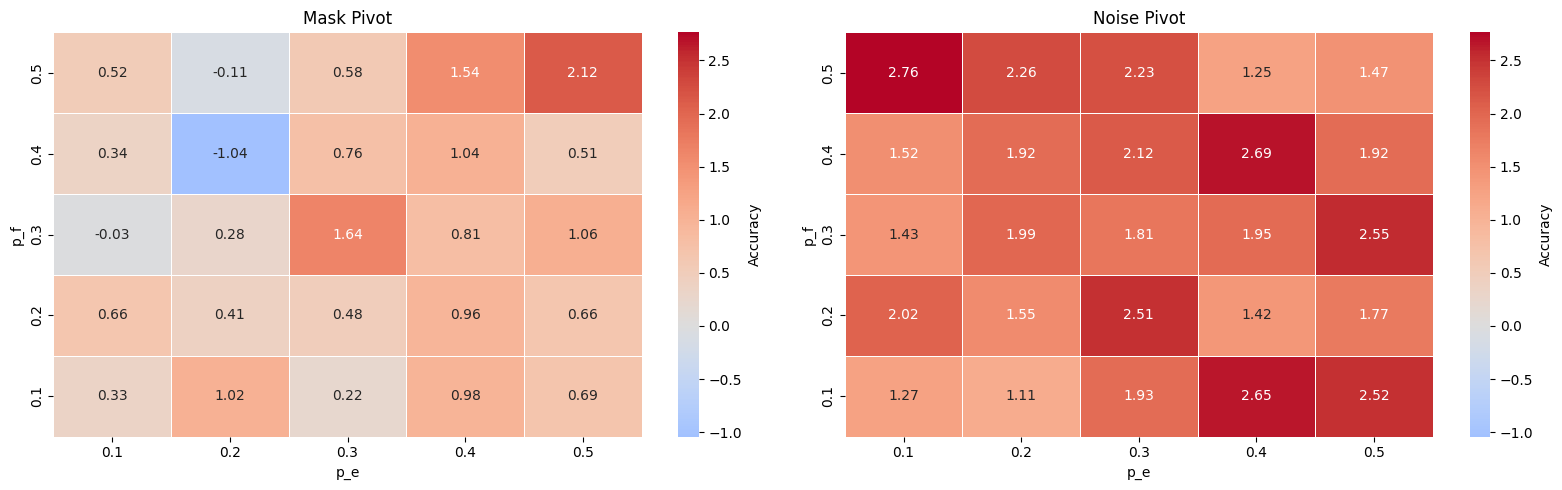

In [25]:
cora_sgc = df_combineds[("cora_ml", "sgc")][0]
baseline = cora_sgc.loc["aleatoric_propagated_None"]["28_mean"]
cora_sgc["28_mean_shifted"] = cora_sgc["28_mean"] - baseline
cora_sgc_tta = cora_sgc[cora_sgc.index.str.contains("aleatoric") & ~cora_sgc.index.str.contains("None")].copy()
cora_sgc_tta = process_tta(cora_sgc_tta)
cora_sgc_tta_pivot_mask, cora_sgc_tta_pivot_noise, vmin, vmax = create_tta_pivots(cora_sgc_tta, "28_mean_shifted")

fig, axes = plt.subplots(1, 2, figsize=(16,5))

# Plot for tta_pubmed_noise_pivot
sns.heatmap(cora_sgc_tta_pivot_mask, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Mask Pivot")

# Plot for tta_pubmed_mask_pivot
sns.heatmap(cora_sgc_tta_pivot_noise, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Noise Pivot")

plt.tight_layout()
plt.show()


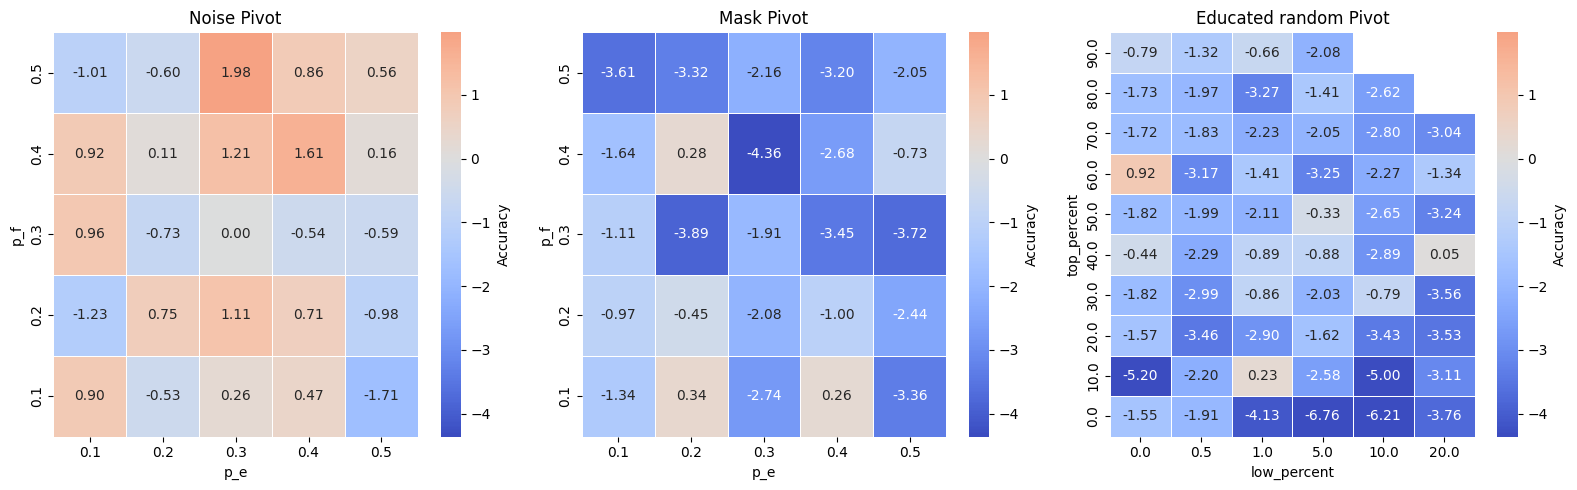

In [14]:
acc_col = "12_mean_shifted"

df_pubmed_gcn = df_combineds[("pubmed","gcn")][0]
base = df_pubmed_gcn.loc["aleatoric_propagated_None"]["12_mean"]
df_pubmed_gcn["12_mean_shifted"] = df_pubmed_gcn["12_mean"] - base

df_pubmed_gcn["strategy"] = [x.split("_")[0] for x in df_pubmed_gcn.index]
tta_pubmed = df_pubmed_gcn[(df_pubmed_gcn["strategy"] == "aleatoric") & df_pubmed_gcn.index.str.contains("probs") ].copy()
tta_pubmed = process_tta(tta_pubmed)

tta_pubmed_mask_pivot, tta_pubmed_noise_pivot, vmin, vmax = create_tta_pivots(tta_pubmed, acc_col)




educated_pubmed = df_pubmed_gcn[(df_pubmed_gcn["strategy"] == "educated")].copy()
educated_pubmed["top_percent"] = educated_pubmed.index.map(lambda x: x.split("_")[-2])
educated_pubmed["top_percent"] = educated_pubmed["top_percent"].astype(float)
educated_pubmed["low_percent"] = educated_pubmed.index.map(lambda x: x.split("_")[-1])
educated_pubmed["low_percent"] = educated_pubmed["low_percent"].astype(float)

educated_pubmed_pivot = educated_pubmed.pivot(index="top_percent", columns="low_percent", values=acc_col)
educated_pubmed_pivot.sort_index(axis=0, ascending=False, inplace=True)


fig, axes = plt.subplots(1, 3, figsize=(16,5))

# Plot for tta_pubmed_noise_pivot
sns.heatmap(tta_pubmed_noise_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Noise Pivot")

# Plot for tta_pubmed_mask_pivot
sns.heatmap(tta_pubmed_mask_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Mask Pivot")

sns.heatmap(educated_pubmed_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[2])
axes[2].set_title("Educated random Pivot")

plt.tight_layout()
plt.show()
# vmin = min(tta_pubmed_mask_pivot.min().min(), tta_pubmed_noise_pivot.min().min(), educated_pubmed_pivot.min().min())
# vmax = max(tta_pubmed_mask_pivot.max().max(), tta_pubmed_noise_pivot.max().max(), educated_pubmed_pivot.max().max())

In [17]:
df_pubmed_gcn[["12_mean"]].head(10)

,12_mean
age_fnoise_emask_100_filter_probs_0.1_0.3,75.275494
age_fnoise_emask_100_filter_probs_0.3_0.4,74.956874
age_fnoise_emask_100_filter_probs_0.2_0.2,74.948756
age_fnoise_emask_100_filter_probs_0.2_0.1,74.877727
age_fmask_emask_200_filter_probs_0.5_0.4,74.868595
age_fnoise_emask_100_filter_probs_0.2_0.4,74.753932
age_fnoise_emask_100_filter_probs_0.3_0.5,74.577372
age_fnoise_emask_100_filter_probs_0.1_0.1,74.534754
age_fnoise_emask_100_filter_probs_0.2_0.5,74.451547
age_fnoise_emask_100_filter_probs_0.4_0.5,74.335870


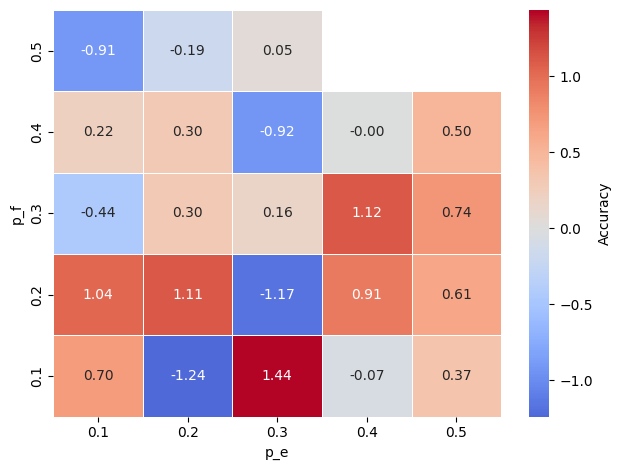

In [15]:
base = df_pubmed_gcn.loc["age_None"]["12_mean"]

df_pubmed_gcn["12_mean_shifted"] = df_pubmed_gcn["12_mean"] - base

age_pubmed = df_pubmed_gcn[(df_pubmed_gcn["strategy"] == "age") & ~(df_pubmed_gcn.index.str.contains("None")) ].copy()
age_pubmed = process_tta(age_pubmed)
age_pubmed_mask_pivot, age_pubmed_noise_pivot, vmin, vmax = create_tta_pivots(age_pubmed, acc_col)



sns.heatmap(age_pubmed_noise_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0)

plt.tight_layout()
plt.show()

In [27]:
df_combined, df = create_df(all_metrics[("cora_ml", "gcn")])
# df_combined.to_csv("../other_data/cora_ml_gcn.csv")
# df_combined = pd.read_csv("../other_data/cora_ml_gcn.csv", index_col=0)

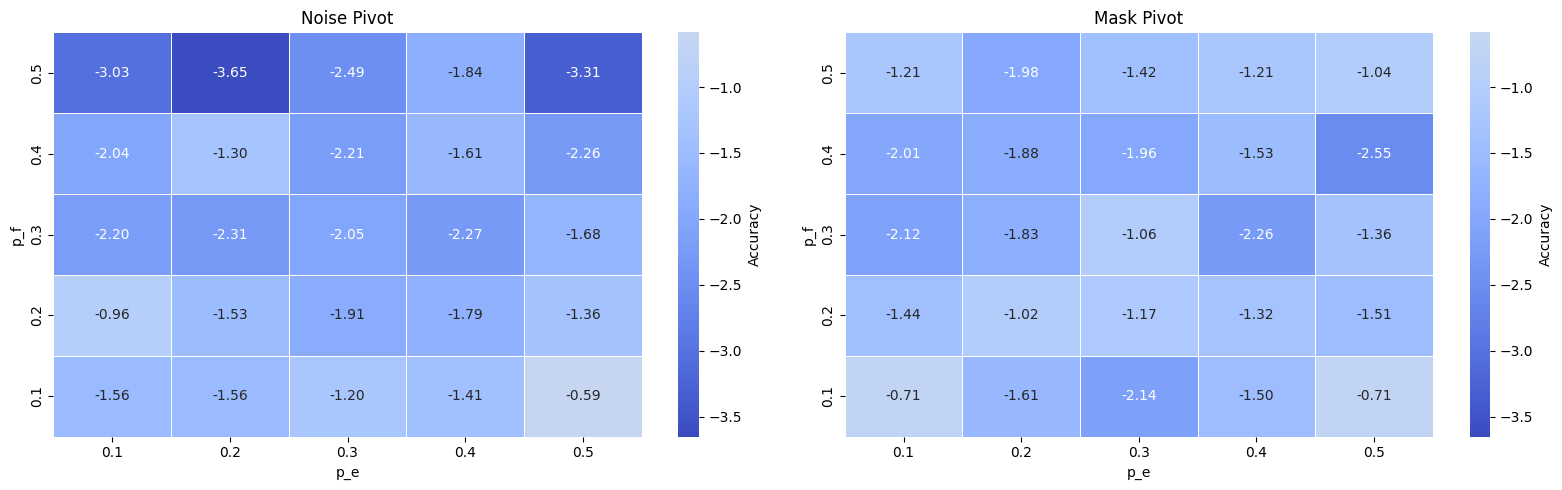

In [28]:
baseline = df_combined.loc["age_None"]["28_mean"]
age_df = df_combined[df_combined.index.str.contains("age") & ~df_combined.index.str.contains("None") ].copy()
age_df = process_tta(age_df)
age_df["28_mean_shifted"] = age_df["28_mean"] - baseline
age_mask_pivot, age_noise_pivot, vmin, vmax = create_tta_pivots(age_df, "28_mean_shifted")

fig, axes = plt.subplots(1, 2, figsize=(16,5))

# Plot for tta_pubmed_noise_pivot
sns.heatmap(age_noise_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Noise Pivot")

# Plot for tta_pubmed_mask_pivot
sns.heatmap(age_mask_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Mask Pivot")

plt.tight_layout()
plt.show()

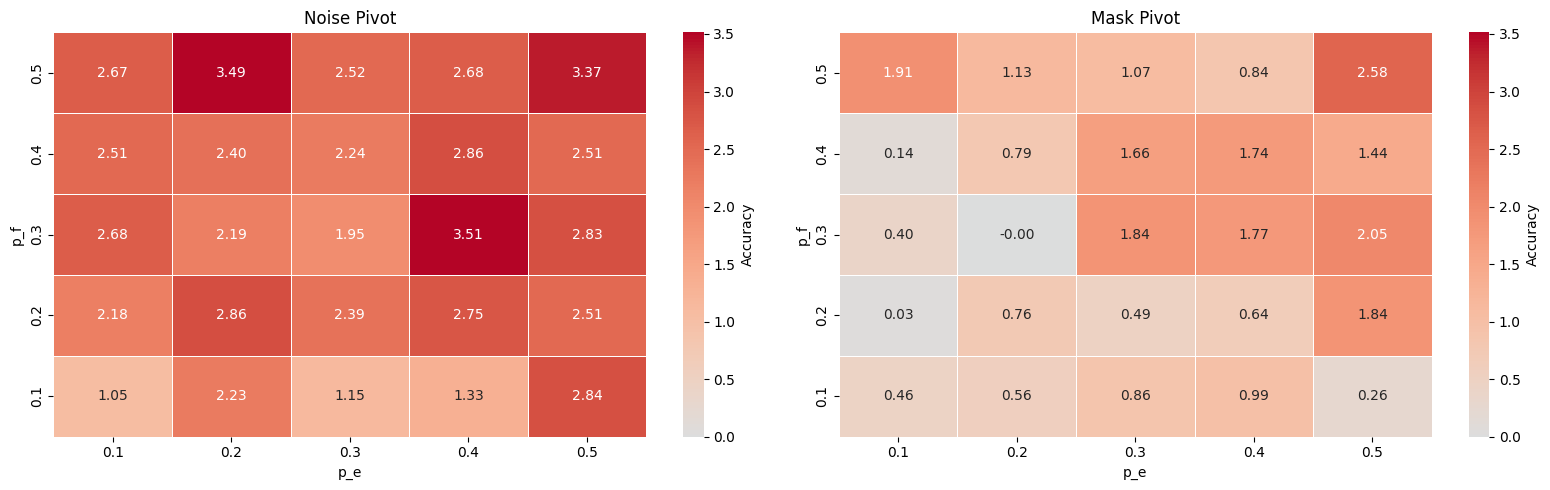

In [29]:
baseline = df_combined.loc["entropy_None"]["28_mean"]
entropy_df = df_combined[df_combined.index.str.contains("entropy") & df_combined.index.str.contains("probs") & ~df_combined.index.str.contains("None") ].copy()
entropy_df = process_tta(entropy_df)
entropy_df["28_mean_shifted"] = entropy_df["28_mean"] - baseline
age_mask_pivot, age_noise_pivot, vmin, vmax = create_tta_pivots(entropy_df, "28_mean_shifted")

fig, axes = plt.subplots(1, 2, figsize=(16,5))

# Plot for tta_pubmed_noise_pivot
sns.heatmap(age_noise_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Noise Pivot")

# Plot for tta_pubmed_mask_pivot
sns.heatmap(age_mask_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy'}, linewidths=0.5,center=0, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Mask Pivot")

plt.tight_layout()
plt.show()

In [21]:
latent_df = df_combined[df_combined.index.str.contains("latent")].copy()
latent_df["p_f"] = latent_df.index.map(lambda x: x.split("_")[4]).astype(float)
latent_df["p_e"] = np.nan
latent_df["m_f"] = "latent"
latent_df["m_e"] = "none"
latent_df["num"] = 100
latent_df["filter"] = latent_df.index.map(lambda x: "filter" if x.split("_")[-1] == "filter" else "nofilter")

In [22]:
tta_df = df_combined[df_combined.index.str.contains("aleatoric_propagated")& df_combined.index.str.contains("probs_") & ~df_combined.index.str.contains("educated_random") & ~df_combined.index.str.contains("test")& ~df_combined.index.str.contains("nonorm") ].copy()
tta_df = process_tta(tta_df)
tta_df = pd.concat([latent_df, tta_df], axis=0)
tta_df = tta_df[["p_e","p_f","m_e","m_f","num","filter","28_mean", "28_std", "nalc"]]
tta_df_orig = tta_df.copy()
tta_df = tta_df[tta_df["num"] == 100]
tta_df_filter = tta_df[tta_df["filter"] == "filter"]  
tta_df_no_filter = tta_df[tta_df["filter"] == "nofilter"]
tta_df_merged = pd.merge(tta_df_filter, tta_df_no_filter, on=["p_e","p_f","m_e","m_f", "num"], suffixes=("_filter", "_no_filter"), how="right")
tta_df_merged["mean_diff"] = tta_df_merged["28_mean_filter"] - tta_df_merged["28_mean_no_filter"]
tta_df_merged["std_diff"] = tta_df_merged["28_std_filter"] - tta_df_merged["28_std_no_filter"]
tta_df_merged.sort_values(by="mean_diff", ascending=False, inplace=True)
tta_df_merged.reset_index(drop=True, inplace=True)
tta_df_merged.drop(columns=["filter_filter","filter_no_filter"], inplace=True)


In [51]:
tta_df.tail(5)

,p_e,p_f,m_e,m_f,num,filter,28_mean,28_std,nalc
aleatoric_propagated_fmask_enone_100_nofilter_probs_0.8_none,NaN,0.8,none,mask,100,nofilter,73.407143,5.537654,83.806412
aleatoric_propagated_fnoise_enone_100_nofilter_probs_0.2_none,NaN,0.2,none,noise,100,nofilter,73.400000,4.264076,86.377026
aleatoric_propagated_fnoise_enone_100_nofilter_probs_0.8_none,NaN,0.8,none,noise,100,nofilter,72.592857,7.167123,86.383219
aleatoric_propagated_fnone_emask_100_filter_probs_none_0.05,0.05,NaN,mask,none,100,filter,72.292857,6.161243,84.633607
aleatoric_propagated_fmask_enone_100_nofilter_probs_0.9_none,NaN,0.9,none,mask,100,nofilter,70.107142,7.143571,82.390465


In [18]:
tta_df_merged_separate = tta_df_merged[(tta_df_merged["p_e"].isna()) | (tta_df_merged["p_f"].isna())].copy()
tta_df_merged_separate["type"] = tta_df_merged_separate.apply(lambda x: "e" + x["m_e"] if x["m_e"] != "none" else "f" + x["m_f"], axis=1)
tta_df_merged_separate["level"] = tta_df_merged_separate.apply(lambda x: x["p_f"] if not pd.isna(x["p_f"]) else x["p_e"], axis=1)

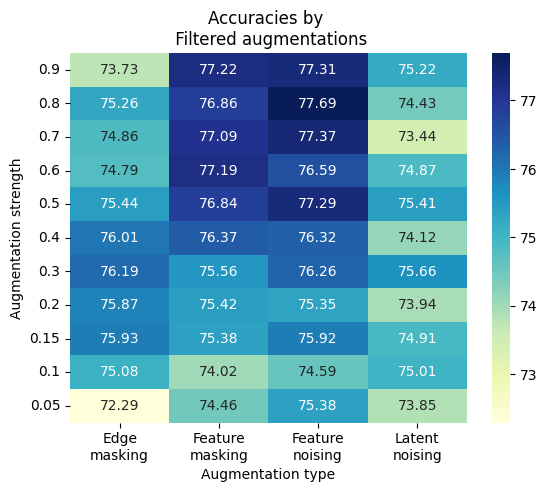

In [19]:
pivot_table = tta_df_merged_separate.pivot(index="level", columns="type", values="28_mean_filter")
pivot_table.sort_index(axis=0, ascending=False, inplace=True)
pivot_table.rename(columns={"emask": "Edge\nmasking", "fmask": "Feature\nmasking", "fnoise": "Feature\nnoising", "flatent": "Latent\nnoising"}, inplace=True)
pivot_table = pivot_table[["Edge\nmasking", "Feature\nmasking", "Feature\nnoising", "Latent\nnoising"]]
ma = pivot_table.max().max()
mi = pivot_table.min().min()
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", vmin=mi, vmax=ma)
plt.title("Accuracies by \n Filtered augmentations")
plt.xlabel("Augmentation type")
plt.ylabel("Augmentation strength")
plt.yticks(rotation=0)
plt.xticks(rotation=0)

plt.show()

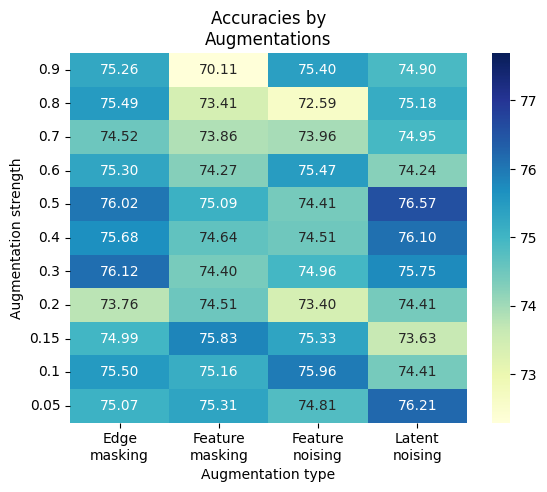

In [20]:
pivot_table = tta_df_merged_separate.pivot(index="level", columns="type", values="28_mean_no_filter")
pivot_table.sort_index(axis=0, ascending=False, inplace=True)
pivot_table.rename(columns={"emask": "Edge\nmasking", "fmask": "Feature\nmasking", "fnoise": "Feature\nnoising", "flatent": "Latent\nnoising"}, inplace=True)
pivot_table = pivot_table[["Edge\nmasking", "Feature\nmasking", "Feature\nnoising", "Latent\nnoising"]]
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", vmin=mi, vmax=ma)
plt.title("Accuracies by\nAugmentations")
plt.xlabel("Augmentation type")
plt.ylabel("Augmentation strength")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

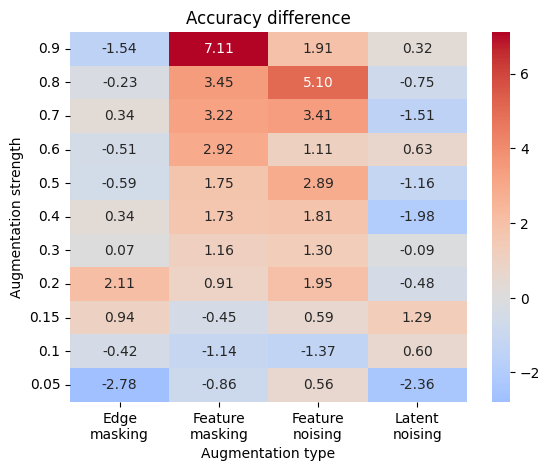

In [21]:
pivot_table = tta_df_merged_separate.pivot(index="level", columns="type", values="mean_diff")
pivot_table.sort_index(axis=0, ascending=False, inplace=True)
pivot_table.rename(columns={"emask": "Edge\nmasking", "fmask": "Feature\nmasking", "fnoise": "Feature\nnoising", "flatent": "Latent\nnoising"}, inplace=True)
pivot_table = pivot_table[["Edge\nmasking", "Feature\nmasking", "Feature\nnoising", "Latent\nnoising"]]
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Accuracy difference")
plt.xlabel("Augmentation type")
plt.ylabel("Augmentation strength")
plt.yticks(rotation=0)
plt.show()


In [ ]:
tta_df_merged_combined_mask = tta_df_merged[~tta_df_merged["p_e"].isna() & ~tta_df_merged["p_f"].isna() & (tta_df_merged["m_f"] == "mask")].copy()
pivot_table_mask = tta_df_merged_combined_mask.pivot(index="p_f", columns="p_e", values="28_mean_no_filter")
pivot_table_mask.sort_index(axis=0, ascending=False, inplace=True)

tta_combined_hyperparam_noise = tta_df_merged[~tta_df_merged["p_e"].isna() & ~tta_df_merged["p_f"].isna() & (tta_df_merged["m_f"] == "noise")].copy()
pivot_table_noise = tta_combined_hyperparam_noise.pivot(index='p_f', columns='p_e', values='28_mean_no_filter')
pivot_table_noise.sort_index(axis=0, ascending=False, inplace=True)

pivot_table_mask_filter = tta_df_merged_combined_mask.pivot(index="p_f", columns="p_e", values="28_mean_filter")
pivot_table_mask_filter.sort_index(axis=0, ascending=False, inplace=True)

pivot_table_noise_filter = tta_combined_hyperparam_noise.pivot(index='p_f', columns='p_e', values='28_mean_filter')
pivot_table_noise_filter.sort_index(axis=0, ascending=False, inplace=True)

pivot_table_mask_diff = tta_df_merged_combined_mask.pivot(index="p_f", columns="p_e", values="mean_diff")
pivot_table_mask_diff.sort_index(axis=0, ascending=False, inplace=True)

pivot_table_noise_diff = tta_combined_hyperparam_noise.pivot(index='p_f', columns='p_e', values='mean_diff')
pivot_table_noise_diff.sort_index(axis=0, ascending=False, inplace=True)

mask_max = max(pivot_table_mask.max().max(), pivot_table_mask_filter.max().max())
mask_min = min(pivot_table_mask.min().min(), pivot_table_mask_filter.min().min())
noise_max = max(pivot_table_noise.max().max(), pivot_table_noise_filter.max().max())
noise_min = min(pivot_table_noise.min().min(), pivot_table_noise_filter.min().min())

min_min = min(mask_min, noise_min)
max_max = max(mask_max, noise_max)

diff_max = max(pivot_table_mask_diff.max().max(), pivot_table_noise_diff.max().max())
diff_min = min(pivot_table_mask_diff.min().min(), pivot_table_noise_diff.min().min())

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Heatmap for pivot_table_mask
sns.heatmap(pivot_table_mask, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[0, 0], vmin=min_min, vmax=max_max)
axs[0, 0].set_title("Accuracies by Feature Masking and Edge Dropping strength")
axs[0, 0].set_ylabel("Feature Masking Probability")
axs[0, 0].set_xlabel("Edge Dropping Probability")

# Heatmap for pivot_table_noise
sns.heatmap(pivot_table_noise, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[0, 1], vmin=min_min, vmax=max_max)
axs[0, 1].set_title("Accuracies by Feature Noising and Edge Dropping strength")
axs[0, 1].set_ylabel("Feature Noising Strength")
axs[0, 1].set_xlabel("Edge Dropping Probability")

# Heatmap for pivot_table_mask_filter
sns.heatmap(pivot_table_mask_filter, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[1, 0], vmin=min_min, vmax=max_max)
axs[1, 0].set_title("Accuracies by Feature Masking and Edge Dropping strength \n Filtered")
axs[1, 0].set_ylabel("Feature Mask Probability")
axs[1, 0].set_xlabel("Edge Dropping Probability")

# Heatmap for pivot_table_noise_filter
sns.heatmap(pivot_table_noise_filter, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[1, 1], vmin=min_min, vmax=max_max)
axs[1, 1].set_title("Accuracies by Feature Noising and Edge Dropping strength \n Filtered")
axs[1, 1].set_ylabel("Feature Noising Strength")
axs[1, 1].set_xlabel("Edge Dropping Probability")


# Heatmap for pivot_table_mask_diff
sns.heatmap(pivot_table_mask_diff, annot=True, fmt=".2f", cmap="coolwarm", ax=axs[2, 0], center=0, vmin=diff_min, vmax=diff_max)
axs[2, 0].set_title("Mean Difference by Feature Masking and Edge Dropping strength")
axs[2, 0].set_ylabel("Feature Mask Probability")
axs[2, 0].set_xlabel("Edge Dropping Probability")

# Heatmap for pivot_table_noise_diff
sns.heatmap(pivot_table_noise_diff, annot=True, fmt=".2f", cmap="coolwarm", ax=axs[2, 1], center=0, vmin=diff_min, vmax=diff_max)
axs[2, 1].set_title("Mean Difference by Feature Noising and Edge Dropping strength")
axs[2, 1].set_ylabel("Feature Noising Strength")
axs[2, 1].set_xlabel("Edge Dropping Probability")

plt.tight_layout()
plt.show()

In [ ]:
sns.heatmap(pivot_table_mask, annot=True, fmt=".2f", cmap="YlGnBu",  vmin=min_min, vmax=max_max)
plt.title("Accuracies by Feature Masking and Edge Dropping strength")
plt.ylabel("Feature Masking Probability")
plt.xlabel("Edge Dropping Probability")

In [ ]:
sns.heatmap(pivot_table_noise, annot=True, fmt=".2f", cmap="YlGnBu",  vmin=min_min, vmax=max_max)
plt.title("Accuracies by Feature Noising and Edge Dropping strength")
plt.ylabel("Feature Noising Strength")
plt.xlabel("Edge Dropping Probability")

In [ ]:
sns.heatmap(pivot_table_mask_filter, annot=True, fmt=".2f", cmap="YlGnBu",  vmin=min_min, vmax=max_max)
plt.title("Accuracies by Feature Masking and Edge Dropping strength \n Filtered")
plt.ylabel("Feature Mask Probability")
plt.xlabel("Edge Dropping Probability")

In [ ]:
sns.heatmap(pivot_table_noise_filter, annot=True, fmt=".2f", cmap="YlGnBu",  vmin=min_min, vmax=max_max)
plt.title("Accuracies by Feature Noising and Edge Dropping strength \n Filtered")
plt.ylabel("Feature Noising Strength")
plt.xlabel("Edge Dropping Probability")

In [ ]:
# Heatmap for pivot_table_mask_diff
sns.heatmap(pivot_table_mask_diff, annot=True, fmt=".2f", cmap="coolwarm",  center=0, vmin=diff_min, vmax=diff_max)
plt.title("Mean Difference by Feature Masking and Edge Dropping strength")
plt.ylabel("Feature Mask Probability")
plt.xlabel("Edge Dropping Probability")



In [ ]:
# Heatmap for pivot_table_noise_diff
sns.heatmap(pivot_table_noise_diff, annot=True, fmt=".2f", cmap="coolwarm",  center=0, vmin=diff_min, vmax=diff_max)
plt.title("Mean Difference by Feature Noising and Edge Dropping strength")
plt.ylabel("Feature Noising Strength")
plt.xlabel("Edge Dropping Probability")

In [ ]:
tta_num = tta_df_orig[(tta_df_orig["p_e"] == 0.4) & (tta_df_orig["p_f"] == 0.5) & (tta_df_orig["m_f"] == "mask") & (tta_df_orig["m_e"] == "mask") & (tta_df_orig["filter"] == "filter")].copy()
tta_num.sort_values(by="num", inplace=True)
ax = tta_num.plot(x="num", y="28_mean", marker='o', figsize=(8, 4), title="Sensitivity to the number of augmented views")
ax.legend().set_visible(False)  # Hide the legend
plt.ylabel("Accuracy")
plt.xlabel("Number of augmented views")
plt.title("Sensitivity to the number of augmented views")
plt.grid(True)
plt.show()

In [ ]:
# Extract adaptation mode, learning rate, and number of epochs from the index
df_adapted = df_combined[df_combined.index.str.contains("feature") | df_combined.index.str.contains("adj") |df_combined.index.str.contains("graph")  ]
df_adapted = df_adapted.copy()
df_adapted['adaptation_mode'] = df_adapted.index.str.split('_').str[2]
# df_adapted['learning_rate'] = df_adapted.index.map(lambda x: x.split('_')[3][3:] if 'adj' in x else (x.split('_')[4][3:] if 'feature' in x else (x.split('_')[3][3:] if 'graph' in x else None)))
df_adapted['learning_rate_adj'] = df_adapted.index.map(lambda x: x.split('_')[3][2:] if 'adj' in x else (x.split('_')[3][3:] if 'graph' in x else None))
df_adapted['learning_rate_feature'] = df_adapted.index.map(lambda x: x.split('_')[3][2:] if 'feature' in x else (x.split('_')[4][3:] if 'graph' in x else None))
df_adapted['epochs'] = df_adapted.index.map(lambda x: x.split('_')[4][6:] if 'graph' not in x else x.split('_')[5][6:])
# df_adapted["learning_rate"] = df_adapted["learning_rate"].astype(float)
df_adapted["epochs"] = df_adapted["epochs"].astype(int)


In [ ]:
df_adapted_features = df_adapted[df_adapted["adaptation_mode"] == "feature"]
pivot_table_feature = df_adapted_features.pivot(index="learning_rate_feature", columns="epochs", values="28_mean")
pivot_table_feature.sort_index(axis=0, ascending=False, inplace=True)

df_adapted_structure = df_adapted[df_adapted["adaptation_mode"] == "adj"]
pivot_table_structure = df_adapted_structure.pivot(index="learning_rate_adj", columns="epochs", values="28_mean")
pivot_table_structure.sort_index(axis=0, ascending=False, inplace=True)

vmin = min(pivot_table_feature.min().min(), pivot_table_structure.min().min())
vmax = max(pivot_table_feature.max().max(), pivot_table_structure.max().max())

In [ ]:

sns.heatmap(pivot_table_feature, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title("Feature Adaptation \n Accuracies by Learning Rate and Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

sns.heatmap(pivot_table_structure, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title("Structure Adaptation \n Accuracies by Learning Rate and Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_adapted_graph = df_adapted[df_adapted["adaptation_mode"] == "graph"]
df_adapted_graph = df_adapted_graph.copy()
le_adj, le_feature = LabelEncoder(), LabelEncoder()
df_adapted_graph["learning_rate_feature_categorical"] = le_feature.fit_transform(df_adapted_graph["learning_rate_feature"])
df_adapted_graph["learning_rate_adj_categorical"] = le_adj.fit_transform(df_adapted_graph["learning_rate_adj"])
df_adapted_graph["epochs_to_plot"] = df_adapted_graph["epochs"]
# Add jitter to learning_rate_feature_categorical, learning_rate_adj_categorical, and epochs
df_adapted_graph["learning_rate_feature_categorical"] = df_adapted_graph["learning_rate_feature_categorical"] + np.random.uniform(-0.01, 0.01, df_adapted_graph.shape[0])
df_adapted_graph["learning_rate_adj_categorical"] = df_adapted_graph["learning_rate_adj_categorical"] + np.random.uniform(-0.01, 0.01, df_adapted_graph.shape[0])
df_adapted_graph["epochs_to_plot"] = df_adapted_graph["epochs_to_plot"] + np.random.uniform(-0.1, 0.1, df_adapted_graph.shape[0])
import plotly.express as px
df_adapted_graph.sort_values(by="28_mean", ascending=False, inplace=True)


In [ ]:
df_adapted_graph_cp = df_adapted_graph.copy()
df_adapted_graph_cp.rename(columns={"28_mean": "accuracy"}, inplace=True)

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assume df has columns: learning_rate1, learning_rate2, epochs, accuracy
model = ols('accuracy ~ C(learning_rate_feature) + C(learning_rate_adj) + C(epochs)', data=df_adapted_graph_cp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Boxplot for learning_rate_feature
sns.boxplot(x="learning_rate_feature", y="28_mean", data=df_adapted_graph, ax=axes[0])
axes[0].set_title("Boxplot of Accuracies by Learning Rate (Feature)")
axes[0].set_xlabel("Learning Rate (Feature)")
axes[0].set_ylabel("Accuracy")
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for learning_rate_adj
sns.boxplot(x="learning_rate_adj", y="28_mean", data=df_adapted_graph, ax=axes[1])
axes[1].set_title("Boxplot of Accuracies by Learning Rate (Adj)")
axes[1].set_xlabel("Learning Rate (Adj)")
axes[1].tick_params(axis='x', rotation=45)

# Boxplot for epochs
sns.boxplot(x="epochs", y="28_mean", data=df_adapted_graph, ax=axes[2])
axes[2].set_title("Boxplot of Accuracies by Epochs")
axes[2].set_xlabel("Epochs")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate standard deviations grouped by different parameters
std_learning_rate_feature = df_adapted_graph.groupby(["learning_rate_feature"])["28_mean"].std().mean()
std_learning_rate_adj = df_adapted_graph.groupby(["learning_rate_adj"])["28_mean"].std().mean()
std_epochs = df_adapted_graph.groupby(["epochs"])["28_mean"].std().mean()

# Collect results into a single DataFrame
results_df = pd.DataFrame({
    "Parameter": ["learning_rate_feature", "learning_rate_adj", "epochs"],
    "Mean_Std": [std_learning_rate_feature, std_learning_rate_adj, std_epochs]
})

results_df

In [ ]:
df_adapted_graph_filtered = df_adapted_graph[df_adapted_graph["learning_rate_feature"] == "0.001"]
pivot_table_graph = df_adapted_graph_filtered.pivot(index="learning_rate_adj", columns="epochs", values="28_mean")
pivot_table_graph.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(pivot_table_graph, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title("Graph Adaptation (Feature LR = 0.001) \n Accuracies by Structure LR and Epoch")
plt.xlabel("Epoch")
plt.ylabel("Structure Learning Rate")
plt.show()

In [ ]:
df_adapted_graph_filtered = df_adapted_graph[df_adapted_graph["learning_rate_feature"] == "0.0001"]
pivot_table_graph = df_adapted_graph_filtered.pivot(index="learning_rate_adj", columns="epochs", values="28_mean")
pivot_table_graph.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(pivot_table_graph, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title("Graph Adaptation (Feature LR = 0.0001) \n Accuracies by Structure LR and Epoch")
plt.xlabel("Epoch")
plt.ylabel("Structure Learning Rate")
plt.show()

In [ ]:
df_adapted_graph_filtered = df_adapted_graph[df_adapted_graph["learning_rate_feature"] == "0.01"]
pivot_table_graph = df_adapted_graph_filtered.pivot(index="learning_rate_adj", columns="epochs", values="28_mean")
pivot_table_graph.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(pivot_table_graph, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title("Graph Adaptation (Feature LR = 0.01) \n Accuracies by Structure LR and Epoch")
plt.xlabel("Epoch")
plt.ylabel("Structure Learning Rate")
plt.show()

In [ ]:
import plotly.graph_objects as go
to_plot = df_adapted_graph
constraint_range_min = to_plot.iloc[9]["28_mean"]
constraint_range_max = to_plot.iloc[0]["28_mean"]
custom_colorscale = [
    [0.0, "darkblue"],   # Very low values
    [0.2, "blue"],       # Low values
    [0.4, "lightblue"],  # Mid-low values
    [0.6, "green"],      # Mid values
    [0.725, "lime"],
    [0.85, "yellow"],     # High values
    [1.0, "red"],        # Top values
]

fig = go.Figure(
    go.Parcoords(
        line=dict(
            color=to_plot["28_mean"],
            colorscale=custom_colorscale,
            showscale=True,  # Add this line to display the colorbar
            colorbar=dict(
                title="Mean Accuracy"  # Title for the colorbar
            ),
        ),
        dimensions=[
            {
                "label": "Learning Rate Adj",
                "values": to_plot["learning_rate_adj_categorical"],
                "tickvals": le_adj.transform(le_adj.classes_),
                "ticktext": le_adj.classes_,
                
            },
            {
                "label": "Learning Rate Feature",
                "values": to_plot["learning_rate_feature_categorical"],
                "tickvals": le_feature.transform(le_feature.classes_),
                "ticktext": le_feature.classes_,
                "range": [0, len(le_feature.classes_)-1],
            },
            
            {"label": "Epochs",
             "values": to_plot["epochs_to_plot"],
             "tickvals": np.unique(to_plot["epochs"]),
             "ticktext": np.unique(to_plot["epochs"])},
            {"label": "Mean Accuracy",
             "values": to_plot["28_mean"],
             "range": [to_plot["28_mean"].min(),to_plot["28_mean"].max()+0.0001],
             "constraintrange" : [constraint_range_min,constraint_range_max+0.0001],},
        ],
    )
)
fig.update_layout(
    width=1600,
    height=800,
    title="Combined Structure and Feature Adaptation \n Accuracies by Learning Rate and Epoch"
)
fig.show()

In [ ]:
educated_df = df_combined[df_combined.index.str.contains("educated")].copy()
educated_df = educated_df.drop(index=["educated_random_aleatoric_propagated", "educated_random_aleatoric_propagated_choose_first"], errors='ignore')
educated_df["top_percent"] = educated_df.index.map(lambda x: x.split("_")[-2])
educated_df["top_percent"] = educated_df["top_percent"].astype(float)
educated_df["low_percent"] = educated_df.index.map(lambda x: x.split("_")[-1])
educated_df["low_percent"] = educated_df["low_percent"].astype(float)


In [ ]:
educated_df_base = educated_df[~educated_df.index.str.contains("probs")].copy()
pivot_table_educated = educated_df_base.pivot(index="top_percent", columns="low_percent", values="28_mean")
pivot_table_educated.sort_index(axis=0, ascending=False, inplace=True)

educated_df_augmented = educated_df[educated_df.index.str.contains("probs")].copy()
pivot_table_educated_augmented = educated_df_augmented.pivot(index="top_percent", columns="low_percent", values="28_mean")
pivot_table_educated_augmented.sort_index(axis=0, ascending=False, inplace=True)

pivot_er_diff = pivot_table_educated_augmented - pivot_table_educated 

er_min = min(pivot_table_educated.min().min(), pivot_table_educated_augmented.min().min())
er_max = max(pivot_table_educated.max().max(), pivot_table_educated_augmented.max().max())


In [ ]:
sns.heatmap(pivot_er_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Educated random \nAccuracy difference")
plt.xlabel("Low Percent")
plt.ylabel("Top Percent")
plt.yticks(rotation=0)
plt.show()

In [ ]:

sns.heatmap(pivot_table_educated, annot=True, fmt=".2f", cmap="YlGnBu",vmin=er_min, vmax=er_max)
plt.title("Educated random \nMax Score strategy")
plt.xlabel("Low Percent")
plt.ylabel("Top Percent")
plt.yticks(rotation=0)
plt.show()

In [ ]:
# BETTER ACCURACIES TEND TOWARD UPPER LEFT CORNER -> STRATEGY SCORES NODES CORRECTLY

sns.heatmap(pivot_table_educated_augmented, annot=True, fmt=".2f", cmap="YlGnBu",vmin=er_min, vmax=er_max)
plt.title("Educated random\nMax Score strategy with TTA")
plt.xlabel("Low Percent")
plt.ylabel("Top Percent")
plt.yticks(rotation=0)
plt.show()

In [ ]:
# List all files in the directory that start with "mask"
node_filtering = torch.load("../output2/runs/cora_ml/gcn/aleatoric_propagated/fmask_emask_200_filter_probs_0.5_0.4_test/2025-04-10_13-13-25_5e3a79fb-0ca8-4a4f-821d-aedfe75cb6c1/mask_filter.pt", weights_only=True)
p = "../output2/runs/cora_ml/gcn/aleatoric_propagated/fmask_emask_200_filter_probs_0.5_0.4_test/2025-04-10_13-13-25_5e3a79fb-0ca8-4a4f-821d-aedfe75cb6c1/"
mask_file_names = [f for f in os.listdir(p) if f.startswith("mask") and not f.endswith("filter.pt")]
mask_file_names.sort()
# Print the list of mask files
print(mask_file_names)
mask_files = [torch.load(p + f, weights_only=True) for f in mask_file_names]
pool_masks = torch.stack([m["mask_train_pool"] for m in mask_files],dim=0)
train_masks = torch.stack([m["mask_train"] for m in mask_files],dim=0)

In [ ]:
train_pool_nodes =node_filtering.permute(0,3,1,2)[pool_masks].view(25,-1,28,200).permute(0,2,3,1)
train_nodes =node_filtering.permute(0,3,1,2)[train_masks].view(25,-1,28,200).permute(0,2,3,1)

In [ ]:
# histogram of average node filtering rates
plt.hist(node_filtering.mean(0).mean(-2).mean(0), bins=100)
plt.show()
node_filtering.mean(0).mean(-2).mean(0).shape

In [ ]:
# how different augmentations are
plt.plot(node_filtering.mean(0).mean(-1).std(-1), label="Augmentation")

# how different inits are
plt.plot(node_filtering.mean(-1).mean(-1).std(0), label="Init")

# how different node filter rates are 
plt.plot(node_filtering.mean(0).mean(1).std(-1), label="Nodes")
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example input tensor
tensor = train_pool_nodes.mean(0).mean(1).numpy()
num_bins = 50  # You can adjust this

# Get histogram bin edges (same for all rows)
hist_range = (np.min(tensor), np.max(tensor))
bin_edges = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Initialize an array to hold histogram counts
hist_counts = np.zeros((28, num_bins))

# Compute histograms along axis 0 (each row)
for i in range(28):
    hist_counts[i], _ = np.histogram(tensor[i], bins=bin_edges)

# 3D plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Coordinates for bars
_x = np.arange(28)
_y = bin_centers
_xx, _yy = np.meshgrid(_x, _y, indexing='ij')
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)
dz = hist_counts.ravel()

# Plot
ax.bar3d(x, y, z, dx=0.8, dy=(bin_edges[1] - bin_edges[0]), dz=dz, shade=True)

ax.set_xlabel('Iteration')
ax.set_ylabel('Filtering ratio')
ax.set_zlabel('Frequency')
plt.title('3D Histogram (per row)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example input tensor
tensor = train_pool_nodes.mean(0).mean(1).numpy()
num_bins = 30


hist_range = (np.min(tensor), np.max(tensor))
bin_edges = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Compute histograms per row
hist_counts = np.zeros((28, num_bins))
for i in range(28):
    hist_counts[i], _ = np.histogram(tensor[i], bins=bin_edges)

# Compute mean for each row
row_means = np.mean(tensor, axis=1)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(hist_counts.T, aspect='auto', origin='lower',
           extent=[0, 27, bin_edges[0], bin_edges[-1]],
           cmap='coolwarm')

# Overlay mean line
x_vals = np.arange(28)
plt.plot(x_vals, row_means, color='red', linewidth=2, label='Mean')

# Labels and layout
plt.colorbar(label='Frequency')
plt.xlabel('Row Index')
plt.ylabel('Bin Center')
plt.title('2D Heatmap of Histograms + Mean Line')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example input tensor
tensor = train_pool_nodes.mean(0).mean(1).numpy()
num_bins = 50  # You can adjust this

# Get histogram bin edges (same for all rows)
hist_range = (np.min(tensor), np.max(tensor))
bin_edges = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Initialize an array to hold histogram counts
hist_counts = np.zeros((28, num_bins))

# Compute histograms along axis 0 (each row)
for i in range(28):
    hist_counts[i], _ = np.histogram(tensor[i], bins=bin_edges)

# 3D plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Swapped coordinates for bars
_x = bin_centers  # now x-axis shows histogram bins
_y = np.arange(28)  # now y-axis shows row index
_xx, _yy = np.meshgrid(_x, _y, indexing='ij')  # swap meshgrid axes
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)
dz = hist_counts.T.ravel()  # transpose because we've swapped axes

# Plot
ax.bar3d(x, y, z, dx=(bin_edges[1] - bin_edges[0]), dy=0.8, dz=dz, shade=True)

# Update labels accordingly
ax.set_xlabel('Bin Center')
ax.set_ylabel('Row Index')
ax.set_zlabel('Frequency')



In [ ]:
train_pool_nodes.mean(0).mean(1)[:,0]

In [ ]:


stds = train_pool_nodes.mean(-1).std(-1).mean(0)
mean_values = train_pool_nodes.mean(-1).mean(0).mean(-1)
stds_train = train_nodes.mean(-1).std(-1).mean(0)
mean_values_train = train_nodes.mean(-1).mean(0).mean(-1)
plt.figure(figsize=(10,5))
plt.fill_between(range(mean_values.shape[0]), mean_values - stds, mean_values + stds, alpha=0.2)
plt.fill_between(range(mean_values_train.shape[0]), mean_values_train - stds_train, mean_values_train + stds_train, alpha=0.2)
plt.plot(mean_values, label="Selection pool")
plt.plot(mean_values_train, label="Train set")
plt.xlim(left=0, right=27)
plt.title("Average node filtering ratio by iteration")
plt.xlabel("Iteration")
plt.ylabel("Node filtering ratio")
plt.legend()
plt.show()
stds.shape, mean_values.shape


In [ ]:
stds = node_filtering.mean(-1).std(-1).mean(0)
mean_values = node_filtering.mean(-1).mean(0).mean(-1)
plt.fill_between(range(mean_values.shape[0]), mean_values - stds, mean_values + stds, alpha=0.2)
plt.plot(mean_values)
plt.xlim(left=0, right=27)
plt.title("Average ratio of filtered nodes by iteration")
plt.xlabel("Iteration")
plt.ylabel("Ratio of filtered nodes")
plt.show()
stds.shape, mean_values.shape


In [ ]:
df_combined.head()

In [43]:
tta_df["strat"] = [i.split("_")[0] for i in tta_df.index]

In [40]:
tta_df["iss_mean"] = [init_split_std(accuracies[i])[0] for i in tta_df.index]
tta_df["iss_std"] = [init_split_std(accuracies[i])[1] for i in tta_df.index]
tta_df["std_inside_split"] = [init_split_std(accuracies[i])[2] for i in tta_df.index]
tta_df["std_inside_init"] = [init_split_std(accuracies[i])[3] for i in tta_df.index]

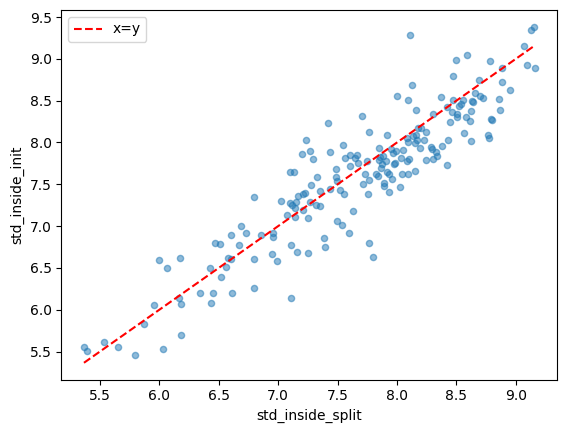

In [41]:
tta_df.plot.scatter(x="std_inside_split", y="std_inside_init", alpha=0.5)
plt.plot([tta_df["std_inside_split"].min(), tta_df["std_inside_split"].max()], 
         [tta_df["std_inside_split"].min(), tta_df["std_inside_split"].max()], 
         color='red', linestyle='--', label='x=y')
plt.legend()

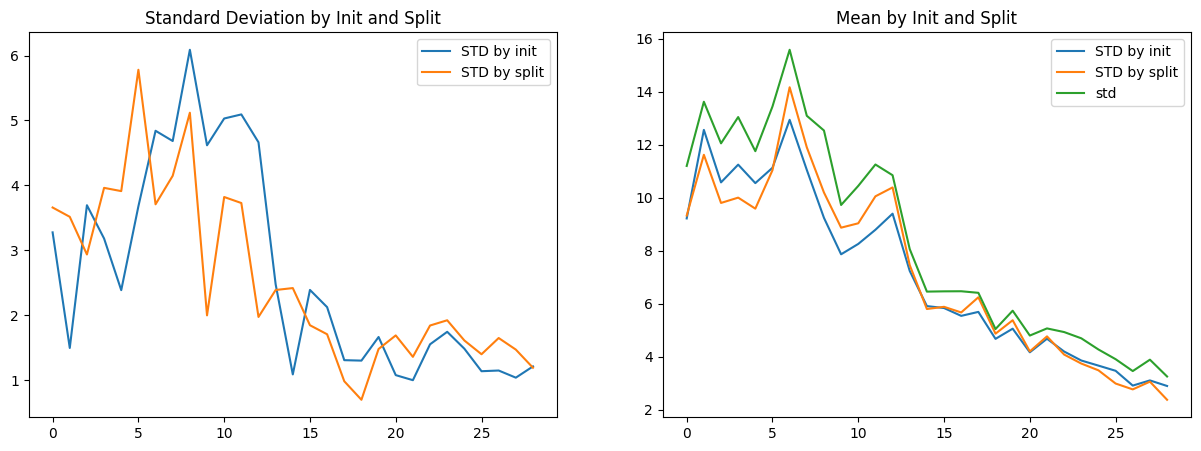

In [5]:
# SENSITIVITY TO SPLIT AND MODEL INITIALIZATION
# GRAPH ADAPTATION BEHAVES WEIRD
# Get the accuracy array
accuracies = {k:v[2] for k,v in metrics_dict_cora_gcn.items()}
accuracy_array = accuracies["aleatoric_propagated_fmask_emask_2000_filter_probs_0.5_0.4"]

# Split the array into bins of 5 items each
bins = np.array(np.array_split(accuracy_array, len(accuracy_array) // 5))

# Calculate the standard deviation for each bin
std_inside_split = np.std(bins, axis=1)
std_inside_init = np.std(bins, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot
axs[0].plot(np.std(std_inside_split, axis=0), label="STD by init")
axs[0].plot(np.std(std_inside_init, axis=0), label="STD by split")
axs[0].legend()
axs[0].set_title("Standard Deviation by Init and Split")

# Second subplot
axs[1].plot(np.mean(std_inside_split, axis=0), label="STD by init")
axs[1].plot(np.mean(std_inside_init, axis=0), label="STD by split")
axs[1].plot(np.std(accuracy_array, axis=0), label="std")
axs[1].legend()
axs[1].set_title("Mean by Init and Split")

plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot std_inside_split
axs[0].plot(std_inside_split.T)
axs[0].set_title("Standard Deviation Inside Split")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Standard Deviation")

# Plot std_inside_init
axs[1].plot(std_inside_init.T)
axs[1].set_title("Standard Deviation Inside Initialization")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()

In [ ]:
df_combined.sort_values(by="28_mean", ascending=False)
df_ranked = df_combined[["5_mean","10_mean", "20_mean", "28_mean"]].rank(ascending=False)
df_ranked["sum"] = df_ranked.sum(axis=1)
df_ranked.sort_values(by="sum", ascending=True, inplace=True)


In [ ]:
df_combined["sum"] = df_combined[["5_mean","10_mean", "20_mean", "28_mean"]].sum(axis=1)
df_combined.sort_values(by="sum", ascending=False)[["5_mean","10_mean", "20_mean", "28_mean","sum"]].head(20)

In [ ]:
def get_count_dict(t):
    ixs = torch.tensor([l[1:] for l in t["acquired_idxs"][:10]]).flatten()
    count = torch.bincount(ixs)
    keys = torch.where(count)
    count_dict = {k.item():count[k].item() for k in keys[0]}
    return count_dict, count,ixs

In [ ]:
metrics_dict_cora_gcn.keys()

In [ ]:
# CORA SGC TTA
df_cora_sgc_tta = df_combined[df_combined.index.str.contains("aleatoric_propagated") & df_combined.index.str.contains("probs") & ~df_combined.index.str.contains("educated")].copy()

df_cora_sgc_tta = process_tta(df_cora_sgc_tta)

df_cora_sgc_tta = df_cora_sgc_tta[df_cora_sgc_tta["num"] == 100] 
df_cora_sgc_tta_mask = df_cora_sgc_tta[df_cora_sgc_tta["m_f"] == "mask"]
df_cora_sgc_tta_noise = df_cora_sgc_tta[df_cora_sgc_tta["m_f"] == "noise"]
pivot_table_sgc_mask = df_cora_sgc_tta_mask.pivot(index="p_f", columns="p_e", values="28_mean")
pivot_table_sgc_mask.sort_index(inplace=True, ascending=False)
pivot_table_sgc_noise = df_cora_sgc_tta_noise.pivot(index="p_f", columns="p_e", values="28_mean")
pivot_table_sgc_noise.sort_index(inplace=True, ascending=False)

In [ ]:
l = [get_count_dict(metrics_dict_cora_gcn[x][3]) for x in tta_df.index]
tta_df["num_acquired_indices"] = [len(i[0]) for i in l]
tta_df["num_acquired_indices"] /= 700
tta_df["max_acquired"] = [i[1].max().item() for i in l]
tta_df["max_acquired_index"] = [i[1].argmax().item() for i in l]

tta_df_combined_mask = tta_df[~tta_df["p_e"].isna() & ~tta_df["p_f"].isna() & (tta_df["m_f"] == "noise")& (tta_df["filter"] == "nofilter")]
pt = tta_df_combined_mask.pivot(index="p_f", columns="p_e", values="num_acquired_indices").sort_index(ascending=False)
sns.heatmap(pt, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)

In [ ]:
key1 = "aleatoric_propagated_fmask_emask_200_filter_probs_0.5_0.4"
key2 = "geem"


count_dict_1, count_1, ixs_1 = get_count_dict(metrics_dict_cora_gcn[key1][3])
# count_dict_1, count_1, ixs_1 = get_count_dict(runs)
print(f"Maximally acquired index: {count_1.argmax()} with {count_1.max()} acquisitions")

count_dict_2, count_2, ixs_2 = get_count_dict(metrics_dict_cora_gcn[key2][3])
print(f"Maximally acquired index: {count_2.argmax()} with {count_2.max()} acquisitions")
print("------")

print(f"Intersection of acquired indices: {len(set(count_dict_1.keys()).intersection(set(count_dict_2.keys())))}")
print(f"Union of acquired indices: {len(set(count_dict_1.keys()).union(set(count_dict_2.keys())))}")
print(f"{key1} acquired indices: {len(count_dict_1)}")
print(f"{key2} acquired indices: {len(count_dict_2)}")

In [ ]:
[k for k in metrics_dict_cora_gcn.keys() if k.startswith("aleatoric_propagated_fnoise_emask_100_filter_probs")]

In [ ]:
[metrics_dict_cora_gcn[x] for x in big_cora_df.index]

In [ ]:
d = []
for k,v in metrics_dict_cora_gcn.items():
    cd, c, i = get_count_dict(v[3])
    d.append([k,len(cd), c.max().item(), c.argmax().item()])

count_dict_df = pd.DataFrame(d, columns=["key", "num_acquired_indices", "max_acquisitions", "max_acquisition_index"])
count_dict_df.sort_values(by="num_acquired_indices", ascending=True, inplace=True)
count_dict_df

In [ ]:
count_dict, count, ixs =  get_count_dict(metrics_dict_cora_gcn[key1][3])

plt.hist(list(count_dict.values()), bins=100)
plt.show()